# Clustering with Scikit-learn

In this notebook, we will learn how to perform k-means clustering using scikit-learn in Python.

We will use cluster analysis to generate a big picture model of the weather at a local station using a minute-graunlarity data. In this dataset, we have in the order of millions records. How do we create 12 clusters out of them?

NOTE: The dataset we will use is in a large CSV file called minute_weather.csv. Please download it into the weather directory in your Week-7-MachineLearning folder. The download link is: https://drive.google.com/open?id=0B8iiZ7pSaSFZb3ItQ1l4LWRMTjg

###  Importing the Necessary Libraries

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# import Utils
import pandas as pd
import numpy as np
from  itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

### Creating a Pandas  DataFrame from a CSV file

In [2]:
data = pd.read_csv(r"C:\Users\User\Desktop\My_projects\data\minute_weather.csv")

### Minute weather Data Description

The **minute weather dataset** comes from the same source as the daily weather dataset that we used in the decision tree based classifier notebook. The main difference between these two datasets is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals. Daily weather dataset instead contained processed and well curated data. The data is in the file **minute_weather.csv**, which is a comma-separated file.

As with the daily weather data, this data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

Each row in minute_weather.csv contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

rowID: unique number for each row (Unit: NA)
hpwren_timestamp: timestamp of measure (Unit: year-month-day hour:minute:second)

air_pressure: air pressure measured at the timestamp (Unit: hectopascals)

air_temp: air temperature measure at the timestamp (Unit: degrees Fahrenheit)

avg_wind_direction: wind direction averaged over the minute before the timestamp (Unit: degrees, with 0 means coming from the North, and increasing clockwise)

avg_wind_speed: wind speed averaged over the minute before the timestamp (Unit: meters per second)

max_wind_direction: highest wind direction in the minute before the timestamp (Unit: degrees, with 0 being North and increasing clockwise)

max_wind_speed: highest wind speed in the minute before the timestamp (Unit: meters per second)

min_wind_direction: smallest wind direction in the minute before the timestamp (Unit: degrees, with 0 being North and inceasing clockwise)

min_wind_speed: smallest wind speed in the minute before the timestamp (Unit: meters per second)

rain_accumulation: amount of accumulated rain measured at the timestamp (Unit: millimeters)

rain_duration: length of time rain has fallen as measured at the timestamp (Unit: seconds)

relative_humidity: relative humidity measured at the timestamp (Unit: percent)

In [3]:
data.shape

(1587257, 13)

In [4]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [5]:
data.isnull().any()

rowID                 False
hpwren_timestamp      False
air_pressure          False
air_temp              False
avg_wind_direction     True
avg_wind_speed         True
max_wind_direction     True
max_wind_speed         True
min_wind_direction     True
min_wind_speed         True
rain_accumulation      True
rain_duration          True
relative_humidity     False
dtype: bool

In [6]:
data["avg_wind_direction"].isnull().any()

True

### Data Sampling

lots of row ,so lets sample down by taking every 10th row

In [7]:
sample_df = data[(data["rowID"] % 10) == 0]
sample_df.shape

(158726, 13)

In [8]:
sample_df

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
10,10,2011-09-10 00:10:49,912.3,62.24,144.0,1.2,167.0,1.8,115.0,0.6,0.0,0.0,38.5
20,20,2011-09-10 00:20:49,912.2,63.32,100.0,2.0,122.0,2.5,91.0,1.5,0.0,0.0,58.3
30,30,2011-09-10 00:30:49,912.2,62.60,91.0,2.0,103.0,2.4,71.0,1.4,0.0,0.0,57.9
40,40,2011-09-10 00:40:49,912.2,64.04,81.0,2.6,88.0,2.9,68.0,1.4,0.0,0.0,57.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587210,1587210,2014-09-10 23:13:29,915.9,75.56,330.0,1.0,341.0,1.3,310.0,0.8,0.0,0.0,47.8
1587220,1587220,2014-09-10 23:23:29,915.9,75.56,330.0,1.1,341.0,1.4,316.0,0.9,0.0,0.0,48.0
1587230,1587230,2014-09-10 23:33:29,915.9,75.56,344.0,1.4,352.0,1.7,338.0,1.2,0.0,0.0,48.0
1587240,1587240,2014-09-10 23:43:29,915.9,75.20,359.0,1.3,9.0,1.6,347.0,1.0,0.0,0.0,46.3


### Stastics

In [9]:
sample_df.describe()

,rowID,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
count,1.587260e+05,158726.000000,158726.000000,158680.000000,158680.000000,158680.000000,158680.000000,158680.000000,158680.000000,158725.000000,158725.000000,158726.000000
mean,7.936250e+05,916.830161,61.851589,162.156100,2.775215,163.462144,3.400558,166.774017,2.134664,0.000318,0.409627,47.609470
std,4.582039e+05,3.051717,11.833569,95.278201,2.057624,92.452139,2.418802,97.441109,1.742113,0.011236,8.665523,26.214409
min,0.000000e+00,905.000000,31.640000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.900000
25%,3.968125e+05,914.800000,52.700000,62.000000,1.300000,68.000000,1.600000,76.000000,0.800000,0.000000,0.000000,24.700000
50%,7.936250e+05,916.700000,62.240000,182.000000,2.200000,187.000000,2.700000,180.000000,1.600000,0.000000,0.000000,44.700000
75%,1.190438e+06,918.700000,70.880000,217.000000,3.800000,223.000000,4.600000,212.000000,3.000000,0.000000,0.000000,68.000000
max,1.587250e+06,929.500000,99.500000,359.000000,31.900000,359.000000,36.000000,359.000000,31.600000,3.120000,2960.000000,93.000000


In [10]:
sample_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [11]:
sample_df[sample_df["rain_accumulation"] == 0].shape

(157812, 13)

In [12]:
sample_df[sample_df["rain_duration"] == 0].shape

(157237, 13)

### Drop all the Rows with Empty rain_duration and rain_accumuation

In [13]:
sample_df.shape

(158726, 13)

In [14]:
# new_sample_df = sample_df.dropna()
del sample_df['rain_accumulation']
del sample_df['rain_duration']

In [15]:
rows_before = sample_df.shape[0]
sample_df  = sample_df.dropna()
rows_after = sample_df.shape[0]

In [16]:
sample_df.shape

(158680, 11)

### To know how many did drop

In [17]:
rows_before - rows_after

46

In [18]:
sample_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

In [19]:
sample_df.shape

(158680, 11)

In [20]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [21]:
select_df = sample_df[features]

In [22]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [23]:
select_df

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4
...,...,...,...,...,...,...,...
1587210,915.9,75.56,330.0,1.0,341.0,1.3,47.8
1587220,915.9,75.56,330.0,1.1,341.0,1.4,48.0
1587230,915.9,75.56,344.0,1.4,352.0,1.7,48.0
1587240,915.9,75.20,359.0,1.3,9.0,1.6,46.3


### Scale the Features using StandardScaler

In [24]:
x = StandardScaler().fit_transform(select_df)
x

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

### Use K-Means Clustering

In [25]:
kmeans = KMeans(n_clusters = 12)
model = kmeans.fit(x)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


### What are the centers of 12 cluster we formed?

In [26]:
centers = model.cluster_centers_
centers

array([[ 1.36622971, -0.08076671, -1.20733272, -0.05002916, -1.07619482,
        -0.02972204, -0.97772303],
       [ 0.06083597, -0.78883033, -1.19668547, -0.57095587, -1.04268893,
        -0.58549224,  0.87831943],
       [-0.21131275,  0.6320397 ,  0.40856163,  0.73504843,  0.51669285,
         0.67302813, -0.15030639],
       [ 0.72972008,  0.43654543,  0.28553119, -0.53490104,  0.47335447,
        -0.54115313, -0.7719126 ],
       [ 0.13097743,  0.84351269,  1.41098879, -0.63843523,  1.67507222,
        -0.58918837, -0.71410644],
       [ 0.25043124, -0.99451039,  0.65941941, -0.54724198,  0.85054515,
        -0.52997605,  1.1586883 ],
       [-1.18047418, -0.87500458,  0.44685689,  1.97823089,  0.53882081,
         1.93970356,  0.91298523],
       [ 1.19047193, -0.25512177, -1.15494803,  2.12376577, -1.05347892,
         2.24052453, -1.13461619],
       [-0.1642132 ,  0.86387888, -1.31101905, -0.58985435, -1.1667173 ,
        -0.60516937, -0.64077777],
       [-0.83946446, -1.1993

### Plots

lets first create some utility , which wil help in the ploting graph

In [27]:
#  Function that create a DataFrame with columns for cluster Numbers
def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append("prediction")
    # zip with a column called "prediction" "index"
    Z = [np.append(A,index) for index,A in enumerate(centers)]
    # Convert to pandas data frame for plot
    P = pd.DataFrame(Z, columns = colNames)
    P["prediction"] = P["prediction"].astype(int)
    return P


In [37]:
# Function that created Parallel plots

def parallel_plot(data):
    my_colors = list(islice(cycle(["b","r","g","y","k"]),None,len(data)))
    plt.figure(figsize = (15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, "prediction", color = my_colors, marker ="o")
    

In [38]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,1.366230,-0.080767,-1.207333,-0.050029,-1.076195,-0.029722,-0.977723,0
1,0.060836,-0.788830,-1.196685,-0.570956,-1.042689,-0.585492,0.878319,1
2,-0.211313,0.632040,0.408562,0.735048,0.516693,0.673028,-0.150306,2
3,0.729720,0.436545,0.285531,-0.534901,0.473354,-0.541153,-0.771913,3
4,0.130977,0.843513,1.410989,-0.638435,1.675072,-0.589188,-0.714106,4
5,0.250431,-0.994510,0.659419,-0.547242,0.850545,-0.529976,1.158688,5
6,-1.180474,-0.875005,0.446857,1.978231,0.538821,1.939704,0.912985,6
7,1.190472,-0.255122,-1.154948,2.123766,-1.053479,2.240525,-1.134616,7
8,-0.164213,0.863879,-1.311019,-0.589854,-1.166717,-0.605169,-0.640778,8
9,-0.839464,-1.199325,0.375193,0.358542,0.473537,0.346439,1.362474,9


### Dry Days

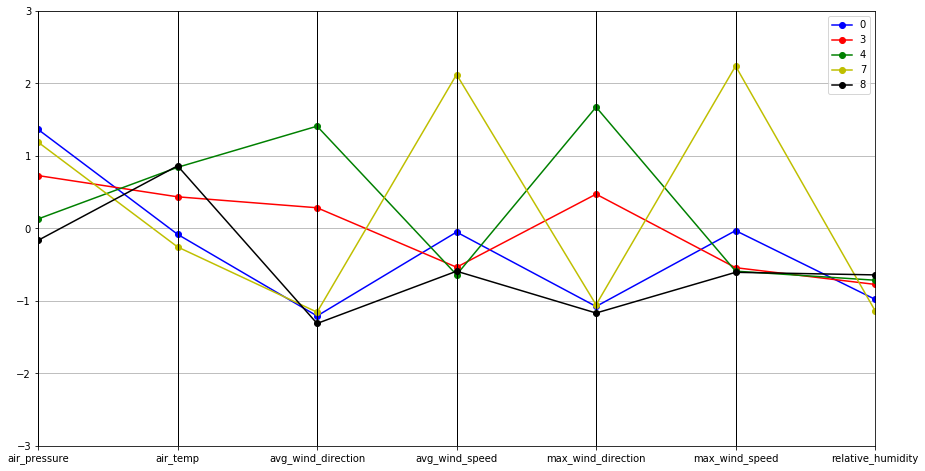

In [39]:
parallel_plot(P[P['relative_humidity'] < -0.5])

### Warm  Days

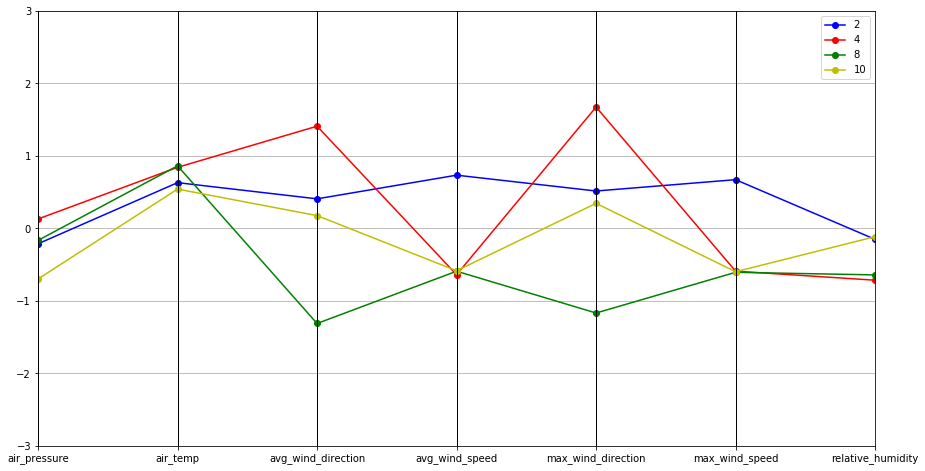

In [45]:
parallel_plot(P[P["air_temp"] > 0.5])

### Cools Days

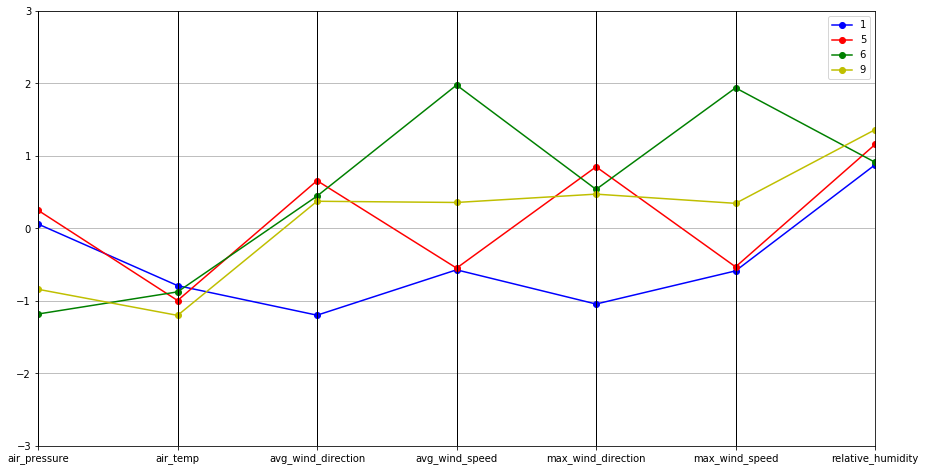

In [50]:
parallel_plot(P[(P["relative_humidity"] > 0.5) & (P["air_temp"] < 0.5)])
# parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])
              